In [1]:
import pandas as pd

df_train = pd.read_csv('melting-point/train.csv')
df_test = pd.read_csv('melting-point/test.csv')

y = df_train['Tm']
X = df_train.drop(columns=['id', 'Tm', 'SMILES'])

In [2]:
from sklearn.feature_selection import VarianceThreshold

selection = VarianceThreshold(threshold=0)
X_clean = selection.fit_transform(X)
feature_names_out = X.columns[selection.get_support()]

In [4]:
from rdkit import Chem
from rdkit.Chem import Descriptors

def get_physics_features(smiles_list):
    features = []
    print("Extracting chemical properties from SMILES...")

    for smile in smiles_list:
        mol = Chem.MolFromSmiles(smile)
        if mol:
            features.append([
                Descriptors.MolWt(mol),
                Descriptors.MolLogP(mol),
                Descriptors.TPSA(mol),
                Descriptors.NumHDonors(mol),
                Descriptors.NumHAcceptors(mol),
                Descriptors.NumRotatableBonds(mol),
                Descriptors.RingCount(mol),
                Descriptors.NumAromaticRings(mol)
            ])
        else:
            # Fallback for corrupted data
            features.append([0]*8)

    cols = ['MolWt', 'LogP', 'TPSA', 'H_Donors', 'H_Acceptors', 'Rotatable_Bonds', 'Ring_Count', 'Aromatic_Rings']
    return pd.DataFrame(features, columns=cols)

In [5]:
X_rdkit = get_physics_features(df_train['SMILES'])

Extracting chemical properties from SMILES...


Text(0, 0.5, 'Melting Point (K)')

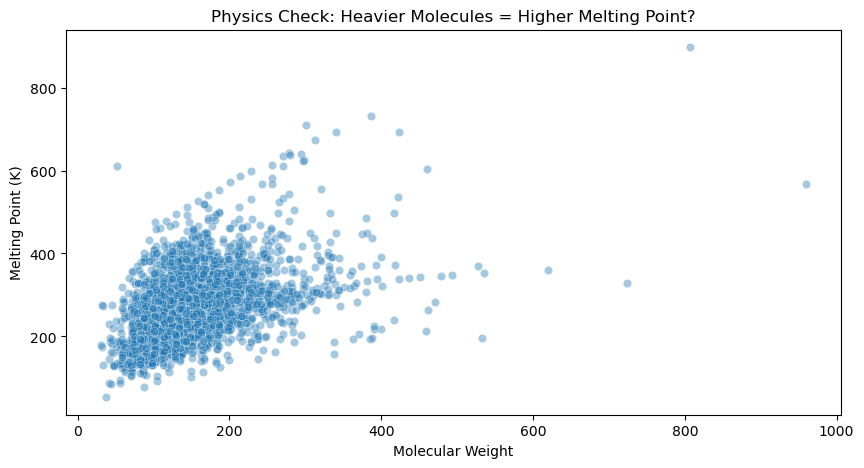

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.scatterplot(x=X_rdkit['MolWt'], y=y, alpha=0.4)
plt.title("Physics Check: Heavier Molecules = Higher Melting Point?")
plt.xlabel("Molecular Weight")
plt.ylabel("Melting Point (K)")

Text(0, 0.5, 'Melting Point (K)')

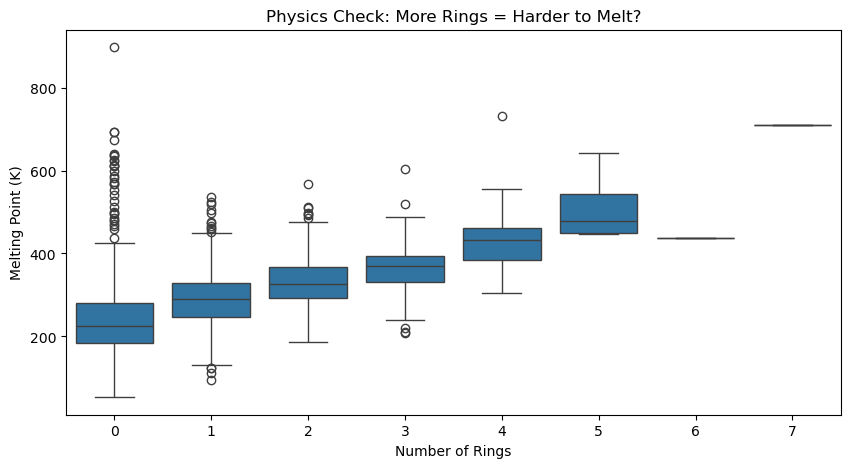

In [9]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=X_rdkit['Ring_Count'], y=y)
plt.title("Physics Check: More Rings = Harder to Melt?")
plt.xlabel("Number of Rings")
plt.ylabel("Melting Point (K)")

In [13]:
import numpy as np

y_log = np.log1p(y)

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_physics_scaled = scaler.fit_transform(X_rdkit)
X_scaled_df = pd.DataFrame(X_physics_scaled, columns=X_rdkit.columns)

In [16]:
X_groups_train = pd.DataFrame(X_clean, columns=feature_names_out)
X_final_train = pd.concat([X_groups_train, X_scaled_df], axis=1)

In [18]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

model_zoo = {
    'Ridge': Ridge(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor()
}

In [19]:
param_grids = {
    'Ridge': {
        'model__alpha': [0.1, 1.0, 10.0]
    },
    'RandomForest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [10, 20, None]
    },
    'GradientBoosting': {
        'model__n_estimators': [100, 200, 500],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 5, 7]
    }
}

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

best_models = {}

for name, model in model_zoo.items():

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    grid = GridSearchCV(
        pipe,
        param_grids[name],
        cv=5,                             # 5-Fold Cross Validation
        scoring='neg_mean_absolute_error',# We want to minimize Error
        n_jobs=-1,                        # Use all CPU cores
        verbose=1
    )

    grid.fit(X_final_train, y_log)

    print(f"   Best Params: {grid.best_params_}")
    print(f"   Best Score (Log MAE): {-grid.best_score_:.4f}")

    best_models[name] = grid.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
   Best Params: {'model__alpha': 10.0}
   Best Score (Log MAE): 0.1369
Fitting 5 folds for each of 6 candidates, totalling 30 fits
   Best Params: {'model__max_depth': 20, 'model__n_estimators': 200}
   Best Score (Log MAE): 0.1182
Fitting 5 folds for each of 27 candidates, totalling 135 fits
   Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 500}
   Best Score (Log MAE): 0.1132


In [22]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor())
])


param_grid = {
    'model__n_estimators': [500, 1000, 2000],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [5, 7, 9],
    'model__subsample': [0.8, 1.0],
    'model__min_samples_leaf': [1, 5]
}

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_final_train, y_log)

print(f"Best Params: {grid.best_params_}")
print(f"Best Score (Log MAE): {-grid.best_score_:.5f}")

# Extract the absolute best model
model = grid.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Params: {'model__learning_rate': 0.05, 'model__max_depth': 7, 'model__min_samples_leaf': 1, 'model__n_estimators': 1000, 'model__subsample': 0.8}
Best Score (Log MAE): 0.11066


In [23]:
X_test_raw_groups = df_test.drop(columns=['id', 'SMILES'])
X_test_groups_clean = selection.transform(X_test_raw_groups)
X_test_groups_df = pd.DataFrame(X_test_groups_clean, columns=feature_names_out)

In [24]:
X_test_rdkit = get_physics_features(df_test['SMILES'])
X_test_physics_scaled = scaler.transform(X_test_rdkit)
X_test_physics_df = pd.DataFrame(X_test_physics_scaled, columns=X_rdkit.columns)

Extracting chemical properties from SMILES...


In [25]:
X_final_test = pd.concat([X_test_groups_df, X_test_physics_df], axis=1)

In [27]:
log_preds = model.predict(X_final_test)
real_preds = np.expm1(log_preds)

In [28]:
submission = pd.DataFrame({'id': df_test['id'], 'Tm': real_preds})
submission.to_csv('submission_optimized.csv', index=False)